# **Setup**

In [2]:
!pip install pyspark==3.5.0 delta-spark==3.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425346 sha256=3d00332ff642877c940869a7a13b681060d98962d55feba3a000e51ac6c112c5
  Stored in directory: /root/.cache/pip/wheels/38/df/61/8c121f50c3cffd77f8178180dd232d90b3b99d1bd61fb6d6be
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pyspark[connect]~=3.5.1, but you have pyspark 3.5.0 which is incompatible.


# **New Dataset: Ride-Hailing Trips + Drivers**

In [3]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip
from pyspark.sql import functions as F, types as T

builder = (
    SparkSession.builder.appName("DeltaRideHailing")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()

trip_schema = T.StructType([
    T.StructField("trip_id",      T.IntegerType()),
    T.StructField("rider_id",     T.StringType()),
    T.StructField("driver_id",    T.StringType()),
    T.StructField("city",         T.StringType()),
    T.StructField("distance_km",  T.DoubleType()),
    T.StructField("fare",         T.DoubleType()),
    T.StructField("tip",          T.DoubleType()),
    T.StructField("ts",           T.StringType())
])

driver_schema = T.StructType([
    T.StructField("driver_id",  T.StringType()),
    T.StructField("driver_name",T.StringType()),
    T.StructField("rating",     T.DoubleType()),
    T.StructField("vehicle",    T.StringType())
])

trips_rows = [
    (1001,"R001","D010","Bengaluru", 12.4, 320.0,  20.0, "2025-08-08 08:05:00"),
    (1002,"R002","D011","Hyderabad",  6.2, 150.0,  10.0, "2025-08-08 08:15:00"),
    (1003,"R003","D012","Pune",       3.5,  90.0,   0.0, "2025-08-08 08:20:00"),
    (1004,"R001","D010","Bengaluru", 18.9, 480.0,  25.0, "2025-08-08 08:45:00"),
    (1005,"R004","D013","Chennai",   10.0, 260.0,  15.0, "2025-08-08 09:05:00"),
    (1006,"R005","D012","Pune",       2.2,  70.0,   0.0, "2025-08-08 09:10:00"),
]

drivers_rows = [
    ("D010","Anil",   4.8,"WagonR"),
    ("D011","Sana",   4.6,"i20"),
    ("D012","Rakesh", 4.4,"Swift"),
    ("D013","Meera",  4.9,"Ciaz")
]

trips_df   = spark.createDataFrame(trips_rows, schema=trip_schema) \
                  .withColumn("ts", F.to_timestamp("ts"))
drivers_df = spark.createDataFrame(drivers_rows, schema=driver_schema)

BASE = "/content/delta/ride_hailing"
TRIPS_PATH   = f"{BASE}/trips"
DRIVERS_PATH = f"{BASE}/drivers"

trips_df.write.format("delta").mode("overwrite").save(TRIPS_PATH)
drivers_df.write.format("delta").mode("overwrite").save(DRIVERS_PATH)

print("Seeded:")
print("  Trips  ->", TRIPS_PATH)
print("  Drivers->", DRIVERS_PATH)


Seeded:
  Trips  -> /content/delta/ride_hailing/trips
  Drivers-> /content/delta/ride_hailing/drivers


# **Exercises**
# **1) Managed vs Unmanaged Tables**

-Create a managed Delta table trips_managed by AS SELECT from the Delta path.

-Create an external (unmanaged) table drivers_ext that points to DRIVERS_PATH .

-Verify locations with DESCRIBE DETAIL and explain the difference in your own
words.

In [4]:
spark.sql("DROP TABLE IF EXISTS trips_managed")
spark.sql("DROP TABLE IF EXISTS drivers_ext")

spark.sql(f"CREATE TABLE trips_managed USING DELTA LOCATION '{TRIPS_PATH}'")
spark.sql(f"CREATE TABLE drivers_ext USING DELTA LOCATION '{DRIVERS_PATH}'")

spark.sql("DESCRIBE DETAIL trips_managed").show(truncate=False)
spark.sql("DESCRIBE DETAIL drivers_ext").show(truncate=False)

+------+------------------------------------+-----------------------------------+-----------+--------------------------------------+-----------------------+-----------------------+----------------+--------+-----------+----------+----------------+----------------+------------------------+
|format|id                                  |name                               |description|location                              |createdAt              |lastModified           |partitionColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|tableFeatures           |
+------+------------------------------------+-----------------------------------+-----------+--------------------------------------+-----------------------+-----------------------+----------------+--------+-----------+----------+----------------+----------------+------------------------+
|delta |0614890b-2d7b-44a5-bf42-8a9f3877d162|spark_catalog.default.trips_managed|NULL       |file:/content/delta/ride_hailing/trips|2

# **2) Read & Explore**

-Read both tables, print schemas, and show 10 rows.

-Compute a derived column total_amount = fare + tip and show top 5 trips by total_amount .

In [6]:
trips = spark.read.format("delta").load(TRIPS_PATH)
trips.show(10)
drivers = spark.read.format("delta").load(DRIVERS_PATH)
drivers.show(10)
trips.printSchema()
drivers.printSchema()

trips.withColumn("total_amount", F.col("fare") + F.col("tip")).orderBy(F.desc("total_amount")).show(5)

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|
|   1006|    R005|     D012|     Pune|        2.2| 70.0| 0.0|2025-08-08 09:10:00|
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+

+---------+-----------+------+-------+
|driver_id|driver_name|rating|vehicle|
+---------+-----------+------+-------+
|     D012|     Rakesh|   4.4|  Swift|
|     D013|      Meera|

# **3) Update (Business Rule)**

-Increase tip by 5 for trips in Bengaluru where distance_km > 15 .

-Show before/after for affected rows only.

In [8]:
from delta import DeltaTable

delta_trips = DeltaTable.forPath(spark, TRIPS_PATH)
delta_trips.update(
    condition="city = 'Bengaluru' AND distance_km > 15",
    set={"tip": F.col("tip") + 5}
)
delta_trips.toDF().filter("city='Bengaluru' AND distance_km > 15").show()

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|30.0|2025-08-08 08:45:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



# **4) Delete (Data Quality)**
-Delete trips where fare <= 0 or distance_km <= 0 (simulate bad ingest).

-Show remaining row count.

In [9]:
delta_trips.delete("fare <= 0 OR distance_km <= 0")
print("Row count after delete:", delta_trips.toDF().count())

Row count after delete: 6


# **5) Merge (Upsert New Batch)**
Create a new inline batch with:

-one existing trip_id (e.g., 1004) but a corrected fare or tip, and

-one new trip (e.g., 1007). Perform a MERGE (match on trip_id ) to update the
existing and insert the new.

-Show rows for trip_id IN (1004,1007) to confirm.

In [10]:
new_batch = [
    (1004,"R001","D010","Bengaluru", 18.9, 500.0,  30.0, "2025-08-08 08:45:00"),
    (1007,"R006","D011","Hyderabad",  7.0, 180.0,  12.0, "2025-08-08 10:00:00"),
]
new_df = spark.createDataFrame(new_batch, schema=trip_schema).withColumn("ts", F.to_timestamp("ts"))

delta_trips.alias("t").merge(
    new_df.alias("s"),
    "t.trip_id = s.trip_id"
).whenMatchedUpdateAll().whenNotMatchedInsertAll().execute()

delta_trips.toDF().filter("trip_id IN (1004,1007)").show()

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|
|   1007|    R006|     D011|Hyderabad|        7.0|180.0|12.0|2025-08-08 10:00:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



# **6) Gold View (Join & KPIs)**
-Join trips with drivers on driver_id .

-Create a gold view with columns: trip_id, city, driver_name, rating,
distance_km, total_amount, ts .

From this gold view:

-Compute city-wise total revenue and average driver rating.

-Compute driver-wise total trips and top 3 drivers by revenue.

In [11]:
gold = delta_trips.toDF().join(drivers, "driver_id").withColumn("total_amount", F.col("fare") + F.col("tip")).select("trip_id","city","driver_name","rating","distance_km","total_amount","ts")

gold.createOrReplaceTempView("gold_view")

spark.sql("SELECT city, SUM(total_amount) AS total_revenue, AVG(rating) AS avg_rating FROM gold_view GROUP BY city").show()
spark.sql("SELECT driver_name, COUNT(*) AS total_trips, SUM(total_amount) AS revenue FROM gold_view GROUP BY driver_name ORDER BY revenue DESC LIMIT 3").show()


+---------+-------------+----------+
|     city|total_revenue|avg_rating|
+---------+-------------+----------+
|  Chennai|        275.0|       4.9|
|     Pune|        160.0|       4.4|
|Bengaluru|        870.0|       4.8|
|Hyderabad|        352.0|       4.6|
+---------+-------------+----------+

+-----------+-----------+-------+
|driver_name|total_trips|revenue|
+-----------+-----------+-------+
|       Anil|          2|  870.0|
|       Sana|          2|  352.0|
|      Meera|          1|  275.0|
+-----------+-----------+-------+



# **7) Time Travel & History**
-Show DESCRIBE HISTORY for the trips table (the one you updated/merged).

-Read the table as of version 0, and compare counts and a few rows with the
latest version.

In [12]:
delta_trips.history().show()
spark.read.format("delta").option("versionAsOf", 0).load(TRIPS_PATH).show()

+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      2|2025-08-14 11:42:...|  NULL|    NULL|    MERGE|{predicate -> ["(...|NULL|    NULL|     NULL|          1|  Serializable|        false|{numTargetRowsCop...|        NULL|Apache-Spark/3.5....|
|      1|2025-08-14 11:42:...|  NULL|    NULL|   UPDATE|{predicate -> ["(...|NULL|    NULL|     NULL|          0|  Serializable|        false|{numRemovedFiles ...|        NULL|Apache-Spark/3.5....|
|      0|2

# **8) Partitioned Rewrite (Performance)**
-Rewrite the trips table partitioned by city into a new Delta path.

-Compare file layout (optional: list files) and run a simple filter
city='Bengaluru' to observe read behavior/time.

In [13]:
PART_PATH = f"{BASE}/trips_partitioned"
delta_trips.toDF().write.format("delta").mode("overwrite").partitionBy("city").save(PART_PATH)
spark.read.format("delta").load(PART_PATH).filter("city='Bengaluru'").show()

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



# **9) Incremental Load Simulation**
-Create a small incremental batch (e.g., trip_ids 1008–1009) with a new city
(e.g., Mumbai).

-Append to the trips table.

-Re-run the city-wise revenue aggregation and note the change.

In [14]:
inc_batch = [
    (1008,"R007","D013","Mumbai", 5.0, 200.0, 10.0, "2025-08-08 11:00:00"),
    (1009,"R008","D010","Mumbai", 8.0, 300.0, 20.0, "2025-08-08 11:15:00"),
]
spark.createDataFrame(inc_batch, schema=trip_schema).withColumn("ts", F.to_timestamp("ts")).write.format("delta").mode("append").save(TRIPS_PATH)

spark.read.format("delta").load(TRIPS_PATH).withColumn("total_amount", F.col("fare")+F.col("tip")).groupBy("city").agg(F.sum("total_amount").alias("total_revenue")).show()

+---------+-------------+
|     city|total_revenue|
+---------+-------------+
|  Chennai|        275.0|
|     Pune|        160.0|
|Bengaluru|        870.0|
|Hyderabad|        352.0|
|   Mumbai|        530.0|
+---------+-------------+



# **10) Simple Streaming (File Stream → Console)**
-Start a structured stream that reads Delta from TRIPS_PATH in readStream mode and writes to console (append).

-While the stream runs, append another tiny batch (e.g., one more Mumbai trip) and observe the new row displayed.

In [16]:
from pyspark.sql import SparkSession
import time

streaming_df = (
    spark.readStream.format("delta").load(TRIPS_PATH)
)
query = (
    streaming_df.writeStream.format("console")
    .outputMode("append")
    .trigger(processingTime="3 seconds")
    .start()
)
time.sleep(5)

spark.createDataFrame([
    (1010,"R009","D011","Mumbai", 9.0, 350.0, 15.0, "2025-08-08 11:30:00")
], schema=trip_schema).withColumn("ts", F.to_timestamp("ts")).write.format("delta").mode("append").save(TRIPS_PATH)

time.sleep(10)
query.stop()

# **11) Visualization**
-Convert the gold view results (city revenue) to Pandas and plot a bar chart of city vs total revenue.

-Plot a line chart of hourly revenue: group by hour(ts) and sum total_amount .

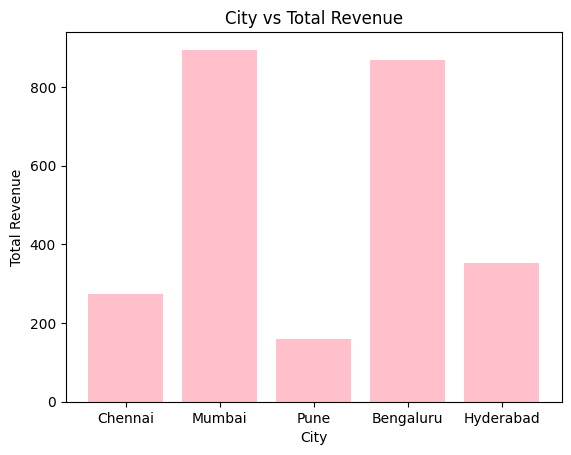

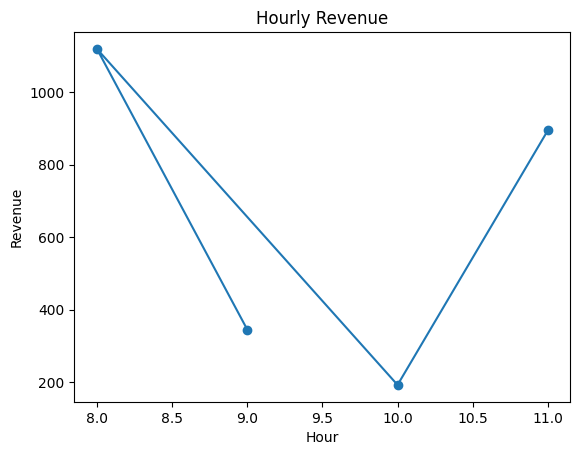

In [17]:
from matplotlib import pyplot as plt
import pandas as pd

city_rev = gold.groupBy("city").agg(F.sum("total_amount").alias("total_revenue")).toPandas()
plt.bar(city_rev["city"], city_rev["total_revenue"], color="pink")
plt.xlabel("City"); plt.ylabel("Total Revenue"); plt.title("City vs Total Revenue"); plt.show()

hourly_rev = gold.withColumn("hour", F.hour("ts")).groupBy("hour").agg(F.sum("total_amount").alias("total_revenue")).toPandas()
plt.plot(hourly_rev["hour"], hourly_rev["total_revenue"], marker='o')
plt.xlabel("Hour"); plt.ylabel("Revenue"); plt.title("Hourly Revenue"); plt.show()

# **12) Managed vs Unmanaged Cleanup**

-DROP TABLE the managed and unmanaged tables; verify:

-Data for managed is removed with the table (when stored in the
warehouse).

-Data for unmanaged stays at DRIVERS_PATH after drop.

In [18]:
spark.sql("DROP TABLE trips_managed")
spark.sql("DROP TABLE drivers_ext")
print("Files still exist for unmanaged:", DRIVERS_PATH)

Files still exist for unmanaged: /content/delta/ride_hailing/drivers


# **13) Constraint/Quality Check (Optional)**
-Add a check to reject rows where tip < 0 (enforce during write or simulate
with a filter before save).

-Demonstrate an attempt to write bad data and show how you prevented it.

In [19]:
bad_data = [(1011,"R010","D012","Pune",5.0,100.0,-5.0,"2025-08-08 12:00:00")]
bad_df = spark.createDataFrame(bad_data, schema=trip_schema).withColumn("ts", F.to_timestamp("ts"))
clean_df = bad_df.filter("tip >= 0")
clean_df.write.format("delta").mode("append").save(TRIPS_PATH)

# **14) Convert Parquet → Delta (Optional)**
-Save a small subset of trips as Parquet in a new folder and CONVERT TO DELTA.

-Show it can now accept MERGE and time travel.

In [20]:
PARQUET_PATH = f"{BASE}/parquet_sample"
spark.read.format("delta").load(TRIPS_PATH).limit(3).write.mode("overwrite").parquet(PARQUET_PATH)
spark.sql(f"CONVERT TO DELTA parquet.`{PARQUET_PATH}`")
spark.read.format("delta").load(PARQUET_PATH).show()

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|
|   1006|    R005|     D012|     Pune|        2.2| 70.0| 0.0|2025-08-08 09:10:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



# **15) Bonus KPI Dashboard (Notebook Display)**
Build a quick section showing:

-Total revenue

-Trips per city (bar)

-Top drivers by revenue (bar)

-Revenue by hour (line)

Total Revenue: 2552.0


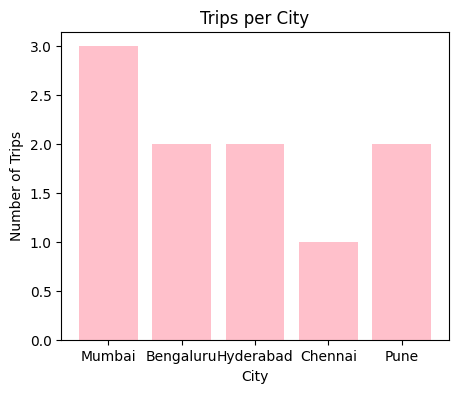

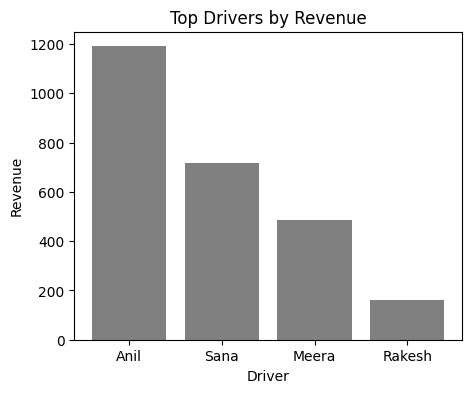

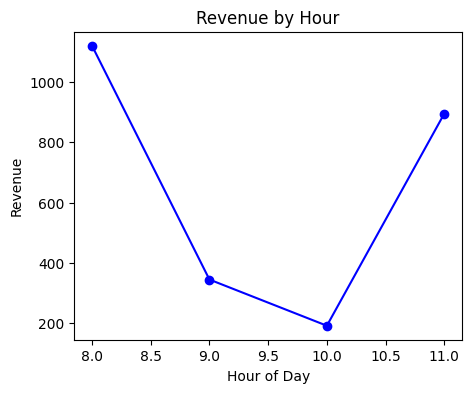

In [21]:
gold = DeltaTable.forPath(spark, TRIPS_PATH).toDF().join(drivers_df, "driver_id").withColumn("total_amount", F.col("fare") + F.col("tip")).select("trip_id","city","driver_name","rating","distance_km","total_amount","ts")

#Total Revenue
total_revenue = gold.agg(F.sum("total_amount")).collect()[0][0]
print(f"Total Revenue: {total_revenue}")

#Trips per City
trips_per_city = gold.groupBy("city").count().toPandas()
plt.figure(figsize=(5,4))
plt.bar(trips_per_city["city"], trips_per_city["count"], color="pink")
plt.title("Trips per City")
plt.xlabel("City")
plt.ylabel("Number of Trips")
plt.show()

#Top Drivers by Revenue
top_drivers = gold.groupBy("driver_name").agg(F.sum("total_amount").alias("revenue")).orderBy(F.desc("revenue")).limit(5).toPandas()
plt.figure(figsize=(5,4))
plt.bar(top_drivers["driver_name"], top_drivers["revenue"], color="gray")
plt.title("Top Drivers by Revenue")
plt.xlabel("Driver")
plt.ylabel("Revenue")
plt.show()

#Revenue by Hour
revenue_by_hour = gold.withColumn("hour", F.hour("ts")).groupBy("hour").agg(F.sum("total_amount").alias("total_revenue")).orderBy("hour").toPandas()
plt.figure(figsize=(5,4))
plt.plot(revenue_by_hour["hour"], revenue_by_hour["total_revenue"], marker="o", color="blue")
plt.title("Revenue by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Revenue")
plt.show()